<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [2]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00


In [3]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/14041604082_ACTIVITY.fit" # @param {type:"string"}

In [4]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [5]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [6]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,heart_rate,cadence,temperature
0,2024-02-19 19:50:40+00:00,0.00,116,0,26
1,2024-02-19 19:50:41+00:00,0.00,114,0,26
2,2024-02-19 19:50:43+00:00,0.00,117,0,26
3,2024-02-19 19:50:48+00:00,0.79,120,72,26
4,2024-02-19 19:50:51+00:00,3.60,123,72,26
...,...,...,...,...,...
1623,2024-02-19 22:27:41+00:00,16495.31,168,54,26
1624,2024-02-19 22:27:47+00:00,16502.59,167,54,26
1625,2024-02-19 22:27:53+00:00,16505.02,167,56,26
1626,2024-02-19 22:27:59+00:00,16505.02,167,54,26


In [7]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

specific_value = df.loc[0, 'timestamp']
specific_value2 = df.loc[1, 'timestamp']
print(specific_value)
print(specific_value2)

time_diff = specific_value2 - specific_value
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-02-19 19:50:40+00:00
2024-02-19 19:50:41+00:00
0 days 00:00:01
1708372240.0


In [8]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  37818


,distance,heart_rate,cadence,temperature,activity_duration_seconds
0,0.00,116,0,26,0.0
4,3.60,123,72,26,11.0
8,36.32,127,73,26,33.0
12,67.95,133,74,26,52.0
16,98.44,142,74,26,69.0
...,...,...,...,...,...
1608,16390.52,170,53,26,9331.0
1612,16419.21,169,52,26,9355.0
1616,16446.76,169,53,26,9379.0
1620,16473.92,170,56,26,9403.0


Number of tokens in resized input prompt  9464


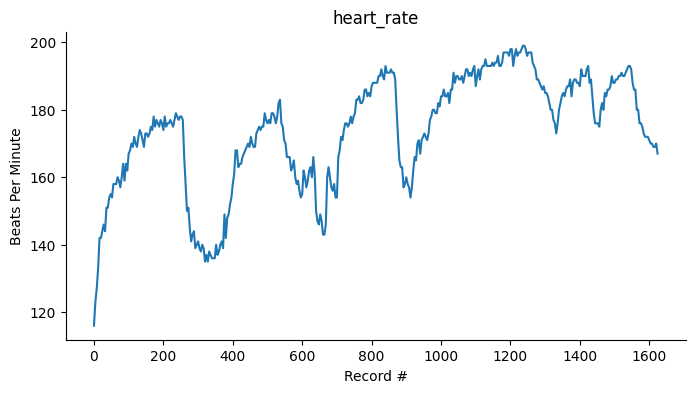

In [9]:
# @title heart_rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='heart_rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

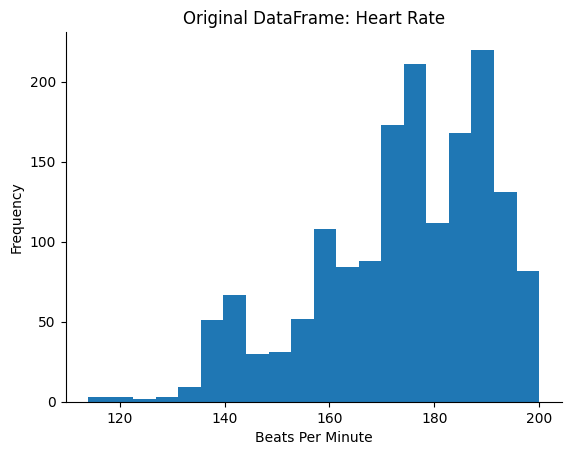

In [10]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

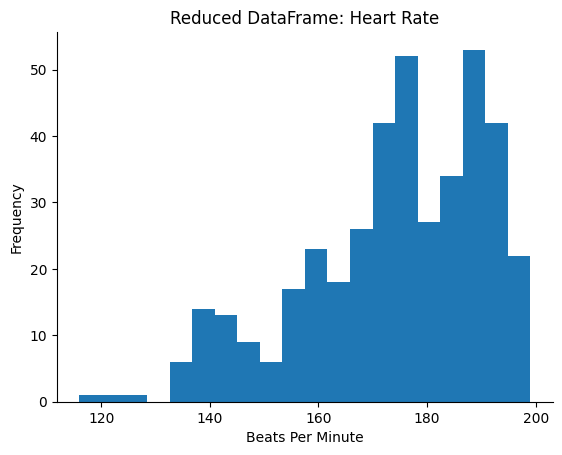

In [11]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

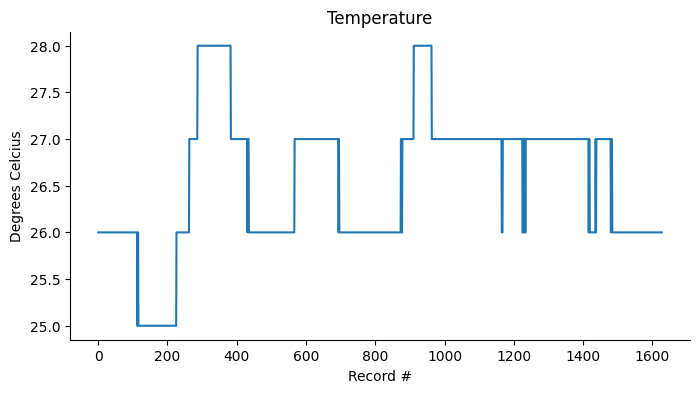

In [12]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

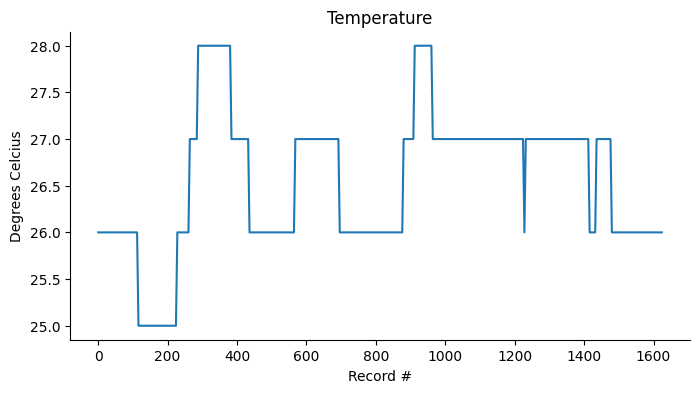

In [13]:
# @title Temperature Over Time Reduced Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
df_for_llm = df_token_limitation

from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))


Number of tokens in input prompt  9464


In [18]:
instructPrompt = """
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

The dataset is provided below"""

request = instructPrompt + df_string

In [19]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [20]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

Here are the key takeaways from the treadmill running data:

1. The total distance covered is 16502.59 meters.
2. The average heart rate during the workout was 180 beats per minute.
3. The average cadence, or steps per minute, was 54.
4. The temperature during the workout was 26 degrees Celsius.
5. The total duration of the activity was 9427 seconds.

To improve your running workouts, here are some recommendations:

1. Increase your distance gradually to build endurance.
2. Pay attention to your heart rate and try to maintain it within a target range for optimal performance and to avoid overexertion.
3. Focus on improving your cadence to increase running efficiency.
4. Stay hydrated and dress appropriately for the temperature to avoid discomfort and potential overheating.
5. Keep track of your workout duration and set goals to gradually increase your workout time.

And here's the summary table for the key metrics:

|    Metric   |   Value   |
|:-----------:|:---------:|
|  Distance   |

In [51]:
instructPromptForMetrics = """

You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please obtain the following information from the dataset that is represented as a string from a Pandas DataFrame:

1. Distance in kilometers
2. Average Pace in minutes/km
3. Heart Rate, which is 'heart_rate' in the DataFrame. Find the average here.
4. Elevation Gain in metres if it exist.
5. Temperature in degrees celcius

You will return this as an ordered as a list from 1 to 5. Only provide the summarized information.

The dataset is provided below"""

requestForMetrics = df_string + instructPromptForMetrics

In [52]:
chatOutputForMetrics = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForMetrics}
                                                      ]
                                            )

In [53]:
metricsSummary = chatOutputForMetrics.choices[0].message.content
print(metricsSummary)

The summarized information from the dataset is as follows:

1. Distance in kilometers: 16502.59 km
2. Average Pace in minutes/km: 6.19 min/km
3. Average Heart Rate: 174.02 bpm
4. Elevation Gain: Not available
5. Temperature: 26℃


In [64]:
instructPromptForAudio = """
Given metrics from a recent run, generate a 1-minute long podcast script. As a running coach, provide an enthusiastic and motivational analysis of their performance, focusing on distance, pace, heart rate, and elevation gain. Include personalized affirmations and encouragement, emphasizing improvement and resilience. Keep the tone optimistic, supportive, and empowering, making the user feel celebrated for their achievements and motivated to continue their running journey."

Instructions:

1. Begin with a Warm Welcome: Start the podcast by greeting the listener and introducing yourself as their running coach. Express excitement about sharing their recent run achievements.
2. Analyze Performance Metrics:
    2.1. Distance: Commend the user on the distance covered, relating it to their dedication and progress.
    2.2. Pace: Reflect on the importance of consistency in pace, encouraging the user to keep moving forward at their own rhythm.
    2.3. Heart Rate: Highlight the effort shown by the heart rate data, connecting physical health to mental resilience.
    2.4. Elevation Gain: Use elevation gain to discuss overcoming challenges, likening hills to life's obstacles that the user is capable of conquering.
3. Incorporate Affirmations: Throughout the analysis, weave in affirmations such as "You are strong", "You are resilient", and "Every step is a victory". Encourage the listener to repeat these affirmations to foster a positive mindset.
4. Conclude with Motivational Encouragement: End the podcast by summarizing the user's achievements, reinforcing their potential for growth, and motivating them to continue their running journey. Encourage them to look forward to their next run with optimism and determination.
5. Keep It Brief and Engaging: Ensure the script is concise enough to fit into a 1-minute segment while being engaging and motivational.
6. Make it one entire transcript with only 1 host speaking. You will only provide what the host will say, and nothing else.
7. Do not use [User's average pace] or any variable names in brackets. Use actual metrics instead of placeholders.
Output Format:

A script suitable for a 1-minute podcast segment, formatted with clear sections for the introduction, analysis of each metric, affirmations, and a motivational conclusion.

The dataset is provided below"""

requestForAudio = metricsSummary + instructPromptForAudio

In [65]:
chatOutputForAudio = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForAudio}
                                                      ]
                                            )

In [66]:
runningSummaryForAudio = chatOutputForAudio.choices[0].message.content
print(runningSummaryForAudio)

[INTRODUCTION]
Host: 
"Hello and welcome to another episode of 'Running Strong'! I'm your host and running coach, here to celebrate your running achievements and inspire you to reach new heights. Today, we'll dive into your recent run and uncover the incredible progress you've made. Let's get started!"

[ANALYSIS OF PERFORMANCE METRICS]
Host: 
"Firstly, congratulations on completing a remarkable run of 16,502.59 kilometers! Your dedication and commitment are truly inspiring. Remember, each step you take brings you closer to your goals, and this distance is evidence of how far you've come."

Host: 
"Consistency is key in any journey, and your average pace of 6.19 minutes per kilometer is a testament to your determination. It's not about comparing yourself to others; it's about embracing your own rhythm and moving forward at a pace that feels good for you. Keep up the great work!"

Host: 
"Your average heart rate of 174.02 beats per minute showcases the incredible effort you put into eac

In [67]:
import re

def remove_text_inside_brackets(text):
    # This pattern matches anything inside square brackets, including the brackets themselves.
    # It accounts for nested brackets as well.
    pattern = r'\[.*?\]'
    # Replace anything that matches the pattern with an empty string.
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

first_pass_text = remove_text_inside_brackets(runningSummaryForAudio)


def remove_host_instances(text):
    # This pattern matches the exact string "Host:".
    pattern = r'Host:'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

second_pass_text = remove_host_instances(first_pass_text)

def remove_empty_lines(text):
    # Split the text into lines, filter out empty or whitespace-only lines, and join back into a single string
    cleaned_text = "\n".join(line for line in text.splitlines() if line.strip())
    return cleaned_text


final_pass_text = remove_empty_lines(second_pass_text)
print(final_pass_text)

"Hello and welcome to another episode of 'Running Strong'! I'm your host and running coach, here to celebrate your running achievements and inspire you to reach new heights. Today, we'll dive into your recent run and uncover the incredible progress you've made. Let's get started!"
"Firstly, congratulations on completing a remarkable run of 16,502.59 kilometers! Your dedication and commitment are truly inspiring. Remember, each step you take brings you closer to your goals, and this distance is evidence of how far you've come."
"Consistency is key in any journey, and your average pace of 6.19 minutes per kilometer is a testament to your determination. It's not about comparing yourself to others; it's about embracing your own rhythm and moving forward at a pace that feels good for you. Keep up the great work!"
"Your average heart rate of 174.02 beats per minute showcases the incredible effort you put into each run. Your physical health and mental resilience go hand in hand, and your hear

In [68]:
from pathlib import Path
from openai import OpenAI
audioClient = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

speech_file_path = "/content/podcast.mp3"
response = audioClient.audio.speech.create(
  model="tts-1",
  voice="echo",
  input=final_pass_text
)

response.stream_to_file(speech_file_path)

<ipython-input-68-d69a82c1abc7>:12: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
